# Final Project Notebook 6 - Topic Modelling 2

## Metadata

```

MacKenzye Leroy (zuf9mc@vriginia.edu)
DS 5001
2 May 2022

Purpose:  This notebook creates a separate topic model for each author in the corpus and explores how those models differ. 
Note: Much of the code in the notebook was originally witten by Dr. Rafael Alverado and has been editted to fit my particular problem 
```

# Set Up

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.decomposition import LatentDirichletAllocation as LDA
import os

In [2]:
#os.chdir('/Users/mackenzyeleroy/Documents/MSDS/DS5001/FinalProject')
home_dir = os.getcwd()
home_dir

'/Users/mackenzyeleroy/Documents/MSDS/DS5001/ETA-Final-Project/FinalProject'

In [3]:
data_home = f"{home_dir}/Data"
parser_lib = f"{home_dir}/lib"
source_files = f'{data_home}/output'
data_prefix = 'wells-verne'

In [4]:
OHCO = ['book_id','chap_id','para_num','sent_num','token_num']

In [5]:
n_terms = 1000
n_topics = 20
max_iter = 20
# n_top_terms = 7
doc_topic_prior = .1 # Prior of document topic distribution alpha. Defaults to 1 / n_components.
topic_word_prior = .1 # Prior of topic word distribution beta. Defaults to 1 / n_components.

In [6]:
BAG = ['book_id', 'chap_id']

# Prepare Data

We work with the count matrix.

In [7]:
BOW = pd.read_csv(f'{data_home}/output/{data_prefix}-BOW.csv').set_index(BAG+['term_str'])
# VOCAB = pd.read_csv(f'{data_home}/output/{data_prefix}-VOCAB2.csv').set_index('term_str')
LIB = pd.read_csv(f'{data_home}/output/{data_prefix}-LIB2.csv').set_index('book_id')

In [8]:
LIB['auth'] = LIB.author.apply(lambda x: x.split(',')[0])

In [9]:
LIB

source_file_path  \
book_id                                                      
35                         WELLS__35__The_Time_Machine.txt   
44278         VERNE__44278__From_the_Earth_to_the_Moon.txt   
1355                 VERNE__1355__The_Underground_City.txt   
159            WELLS__159__The_Island_of_Doctor_Moreau.txt   
5230     WELLS__5230__The_Invisible_Man_A_Grotesque_Rom...   
36                    WELLS__36__The_War_of_the_Worlds.txt   
103        VERNE__103__Around_the_World_in_Eighty_Days.txt   
1013            WELLS__1013__The_First_Men_in_the_Moon.txt   
12163                 WELLS__12163__The_Sleeper_Awakes.txt   
18857    VERNE__18857__A_Journey_to_the_Centre_of_the_E...   
3526              VERNE__3526__Five_Weeks_in_a_Balloon.txt   
3091     VERNE__3091__Eight_Hundred_Leagues_on_the_Amaz...   
16457                VERNE__16457__All_Around_the_Moon.txt   
780                     WELLS__780__The_War_in_the_Air.txt   
1353                      VERNE__1353__Off_on_a_Comet!.txt   
164      VERNE__164__Twenty_Thousand_Leagues_under_the_...   
1059                   WELLS__1059__The_World_Set_Free.txt   
718                            WELLS__718__Tono-Bungay.txt   
6424                      WELLS__6424__A_Modern_Utopia.txt   
1268                VERNE__1268__The_Mysterious_Island.txt   

                                         title        author  \
book_id                                                        
35                            The Time Machine    WELLS, H.G   
44278               From the Earth to the Moon  VERNE, JULES   
1355                      The Underground City  VERNE, JULES   
159                The Island of Doctor Moreau    WELLS, H.G   
5230     The Invisible Man A Grotesque Romance    WELLS, H.G   
36                       The War of the Worlds    WELLS, H.G   
103            Around the World in Eighty Days  VERNE, JULES   
1013                 The First Men in the Moon    WELLS, H.G   
12163                       The Sleeper Awakes    WELLS, H.G   
18857     A Journey to the Centre of the Earth  VERNE, JULES   
3526                   Five Weeks in a Balloon  VERNE, JULES   
3091       Eight Hundred Leagues on the Amazon  VERNE, JULES   
16457                      All Around the Moon  VERNE, JULES   
780                         The War in the Air    WELLS, H.G   
1353                           Off on a Comet!  VERNE, JULES   
164      Twenty Thousand Leagues under the Sea  VERNE, JULES   
1059                        The World Set Free    WELLS, H.G   
718                                Tono-Bungay    WELLS, H.G   
6424                           A Modern Utopia    WELLS, H.G   
1268                     The Mysterious Island  VERNE, JULES   

                                        chap_regex  book_len  n_chaps   auth  
book_id                                                                       
35                      ^\s*CHAPTER\s+[[IVXLCM]+\.     32506       17  WELLS  
44278                    ^\s*CHAPTER\s+[IVXLCM]+\.     40559       28  VERNE  
1355                     ^\s*CHAPTER\s+[IVXLCM]+\.     43662       19  VERNE  
159      (INTRODUCTION.)|^\s*CHAPTER\s+[IVXLCM]+\.     43782       23  WELLS  
5230                     ^\s*CHAPTER\s+[IVXLCM]+\.     48562       28  WELLS  
36                       ^\s*CHAPTER\s+[IVXLCM]+\.     60129       27  WELLS  
103                      ^\s*CHAPTER\s+[IVXLCM]+\.     63114       37  VERNE  
1013                     ^\s*CHAPTER\s+[IVXLCM]+\.     68534       26  WELLS  
12163                         ^CHAPTER\s+[IVXLCM]+     75981       25  WELLS  
18857                              ^CHAPTER\s+\d+$     86039       44  VERNE  
3526                   ^\s*CHAPTER\s+[A-Z';, -]+\.     90793       44  VERNE  
3091                     ^\s*CHAPTER\s+[IVXLCM]+\.     95162       40  VERNE  
16457                    ^\s*CHAPTER\s+[IVXLCM]+\.     97152       24  VERNE  
780                      ^\s*CHAPTER\s+[IVXLCM]+\.     98207       11  WELLS  
1353

In [10]:
# DOC = pd.DataFrame(index=X.index).join(LIB[['auth','title', 'genre']])
# DOC['label'] = DOC.apply(lambda x: f"{x.auth}, {x.title[:10].strip()} ({x.genre[:1]}) {x.name[0]}:{x.name[1]}", 1)

# Define a Topic Model Class

In [11]:
import pandas as pd
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation as LDA, NMF

class TopicModel():            

    bow_count_col:str = 'n'
    n_topics:int = 20
    n_top_terms:int = None
    engine_type = 'LDA' # Also NMF
    n_terms = 1000

    # LDA Params
    max_iter:int = 20
    learning_offset:float = 50.
    random_state:int = 0
    
    # NMF Params
    nmf_init = 'nndsvd'
    nmf_max_iter = 1000
    
    def __init__(self, BOW:pd.DataFrame):
        self.BOW = BOW
        self.LIB = LIB
        
    def create_X(self):
        X = self.BOW[self.bow_count_col].unstack()
        V = X.count().to_frame('df')
        X = X.fillna(0)
        V['idf'] = np.log2(len(X)/V.df)
        V['dfidf'] = V.df * V.idf
        SIGS = V.sort_values('dfidf', ascending=False).head(self.n_terms).index
        self.X = X[SIGS]
        self.V = V              
        
    def get_model(self):
        
        if self.engine_type == 'LDA':
            self.engine = LDA(n_components=self.n_topics, 
                                  max_iter=self.max_iter, 
                                  learning_offset=self.learning_offset, 
                                  random_state=self.random_state)

        elif self.engine_type == 'NMF':
            self.engine = NMF(n_components=self.n_topics, 
                                  max_iter=self.nmf_max_iter,
                                  init=self.nmf_init, 
                                  random_state=1, 
                                  alpha=.1, 
                                  l1_ratio=.5)
                
        self.THETA = pd.DataFrame(self.engine.fit_transform(self.X.values), index=self.X.index)
        self.THETA.columns.name = 'topic_id'
        
        self.PHI = pd.DataFrame(self.engine.components_, columns=self.X.columns)
        self.PHI.index.name = 'topic_id'
        self.PHI.columns.name = 'term_str'
        
        self.TOPIC = self.PHI.sum(1).to_frame('phi_sum')
        self.TOPIC['theta_sum'] = self.THETA.sum()

    def describe_topics(self):
        
        PHI_P = (self.PHI.T / self.PHI.T.sum())
        PHI_I = np.log2(1/PHI_P)
        self.TOPIC['h'] = round((PHI_I * PHI_P).sum().sort_values(ascending=False), 2)
        if not self.n_top_terms:
            self.n_top_terms = round(self.TOPIC.h.mean())
            
        # Compute relevant terms
        self.get_relevant_terms(0)            

        self.TOPIC['top_terms'] = self.PHI.stack().to_frame('topic_weight')\
            .groupby('topic_id')\
            .apply(lambda x: 
                x.sort_values('topic_weight', ascending =False)\
                    .head(self.n_top_terms)\
                    .reset_index()['term_str'])\
            .apply(lambda x: ' '.join(x.replace(' ', '_')), 1)
        
        # Not using top terms from above; using from get_relevant_terms()
        self.TOPIC['label'] = self.TOPIC.apply(lambda x: f"{x.name}: {x.top_terms_rel}", 1)
                
    def get_relevant_terms(self, 𝜆 = .5):
        """
        Compute relevance of topic terms as defined by Sievert and Shirley 2014.
        C. Sievert and K. Shirley, “LDAvis: A Method for Visualizing and Interpreting Topics,” 
        in Proceedings of the workshop on interactive language learning, visualization, and interfaces, 2014, pp. 63–70.
        """
        Ptw = self.PHI.apply(lambda x: x / x.sum(), 1) # L1 norm of PHI rows, i.e. p(w|t)
        Pw = self.PHI.sum() / self.PHI.sum().sum() # Marginal probs of terms in PHI, i.e. p(w)
        self.REL = 𝜆 * np.log2(Ptw) + (1-𝜆) * np.log2(Ptw / Pw)
        self.TOPIC['top_terms_rel'] = self.REL.apply(lambda x: ' '.join(x.sort_values(ascending=False).head(self.n_top_terms).index), 1)

    def get_model_stats(self):
        # p = self.TOPIC.theta_sum / self.TOPIC.theta_sum.sum()
        self.entropy = self.TOPIC.h.sum()
        self.redundancy = 1 - self.entropy / np.log2(self.n_topics)
    
    def get_doc_stats(self):
        self.DOC = (self.THETA.T * np.log2(1/self.THETA.T)).sum().to_frame('entropy')
        self.DOC['max_topic'] = self.THETA.idxmax(1)
        
    def plot_topics(self):
        self.TOPIC.sort_values('theta_sum', ascending=True).plot.barh(y='theta_sum', x='label', figsize=(5, self.n_topics/2))

## Create separate indexes

In [12]:
WELLS_IDX = LIB[LIB.auth == 'WELLS'].index
VERNE_IDX = LIB[LIB.auth == 'VERNE'].index

## Austen

In [13]:
tm_WELLS = TopicModel(BOW.loc[WELLS_IDX])
tm_WELLS.n_topics = n_topics
tm_WELLS.engine_type = 'LDA'
tm_WELLS.create_X()
tm_WELLS.get_model()
tm_WELLS.describe_topics()
tm_WELLS.get_model_stats()
tm_WELLS.get_doc_stats()

In [14]:
tm_WELLS.DOC = BOW.loc[WELLS_IDX].groupby(['book_id','chap_id']).n.sum().to_frame().join(LIB[['auth','title']])
tm_WELLS.DOC['label'] = tm_WELLS.DOC.apply(lambda x: f"{x.auth}, {x.title[:10].strip()}  {x.name[0]}:{x.name[1]}", 1)

In [15]:
tm_WELLS.DOC.head()

n   auth             title                    label
book_id chap_id                                                        
35      1        1691  WELLS  The Time Machine  WELLS, The Time M  35:1
        2        1339  WELLS  The Time Machine  WELLS, The Time M  35:2
        3        2000  WELLS  The Time Machine  WELLS, The Time M  35:3
        4        2094  WELLS  The Time Machine  WELLS, The Time M  35:4
        5        1665  WELLS  The Time Machine  WELLS, The Time M  35:5

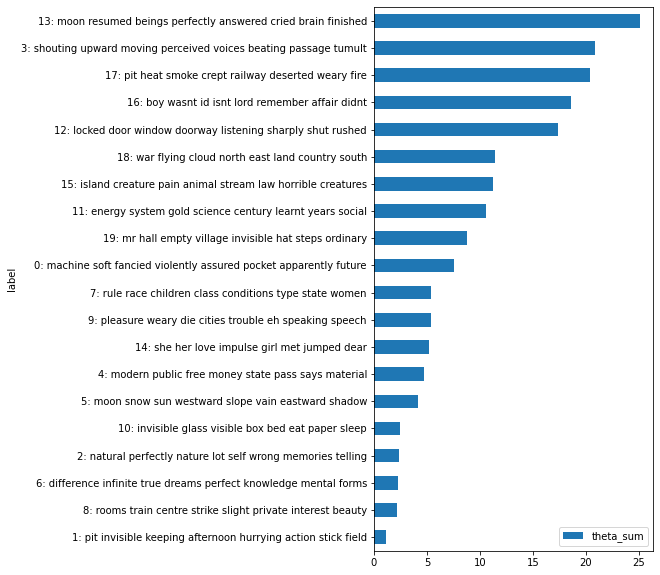

In [16]:
tm_WELLS.plot_topics()

## Melville

In [17]:
tm_VERNE = TopicModel(BOW.loc[VERNE_IDX])
tm_VERNE.n_topics = n_topics
tm_VERNE.create_X()
tm_VERNE.get_model()
tm_VERNE.describe_topics()
tm_VERNE.get_model_stats()
tm_VERNE.get_doc_stats()

In [18]:
tm_VERNE.DOC = BOW.loc[VERNE_IDX].groupby(['book_id','chap_id']).n.sum().to_frame().join(LIB[['auth','title']])
tm_VERNE.DOC['label'] = tm_VERNE.DOC.apply(lambda x: f"{x.auth}, {x.title[:10].strip()}  {x.name[0]}:{x.name[1]}", 1)

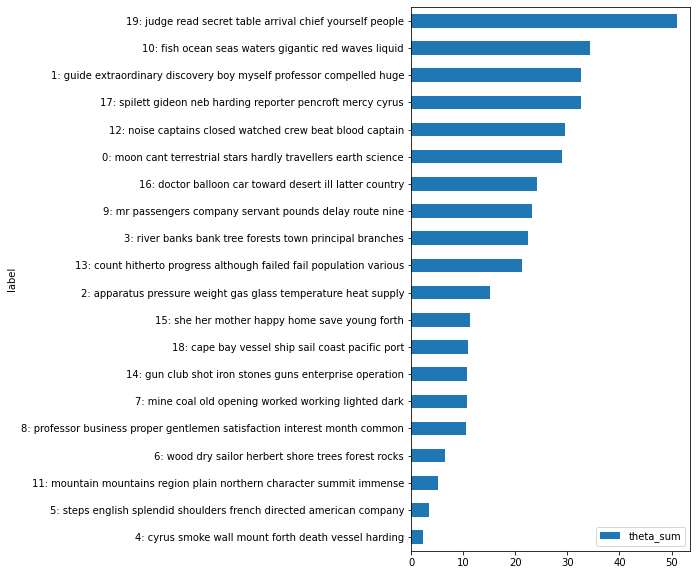

In [19]:
tm_VERNE.plot_topics()

# Visualize

## Heatmaps of Mean Topic per Book

In [20]:
#LIB['label'] = LIB.apply(lambda x: f"{x.author}, {x.title[:10].strip()} {x.name[0]}:{x.name[1]}", 1)

In [21]:
VERNE_IMG = tm_VERNE.THETA.groupby('book_id').mean()
VERNE_IMG.index = LIB.loc[VERNE_IDX].title
VERNE_IMG.columns = tm_VERNE.TOPIC.label

In [22]:
VERNE_IMG.T.style.background_gradient(cmap='GnBu')

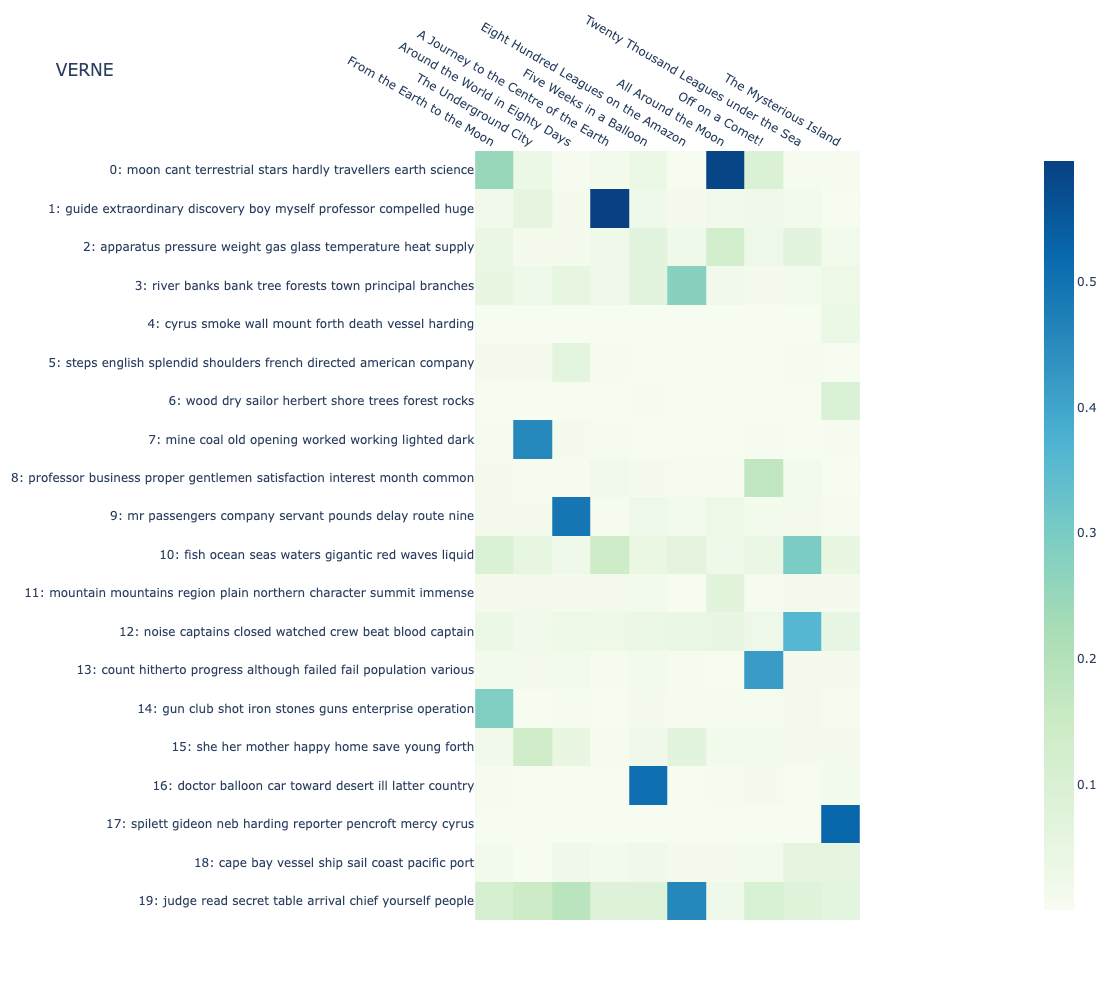

In [23]:
fig = px.imshow(VERNE_IMG.T, color_continuous_scale='GnBu', title="VERNE", height=1000)
fig.update_layout(xaxis={'side': 'top', 'title_text':None}, yaxis={'title_text':None})

In [24]:
WELLS_IMG = tm_WELLS.THETA.groupby('book_id').mean()
WELLS_IMG.index = LIB.loc[WELLS_IDX].title
WELLS_IMG.columns = tm_WELLS.TOPIC.label

In [25]:
WELLS_IMG.T.style.background_gradient(cmap='GnBu')

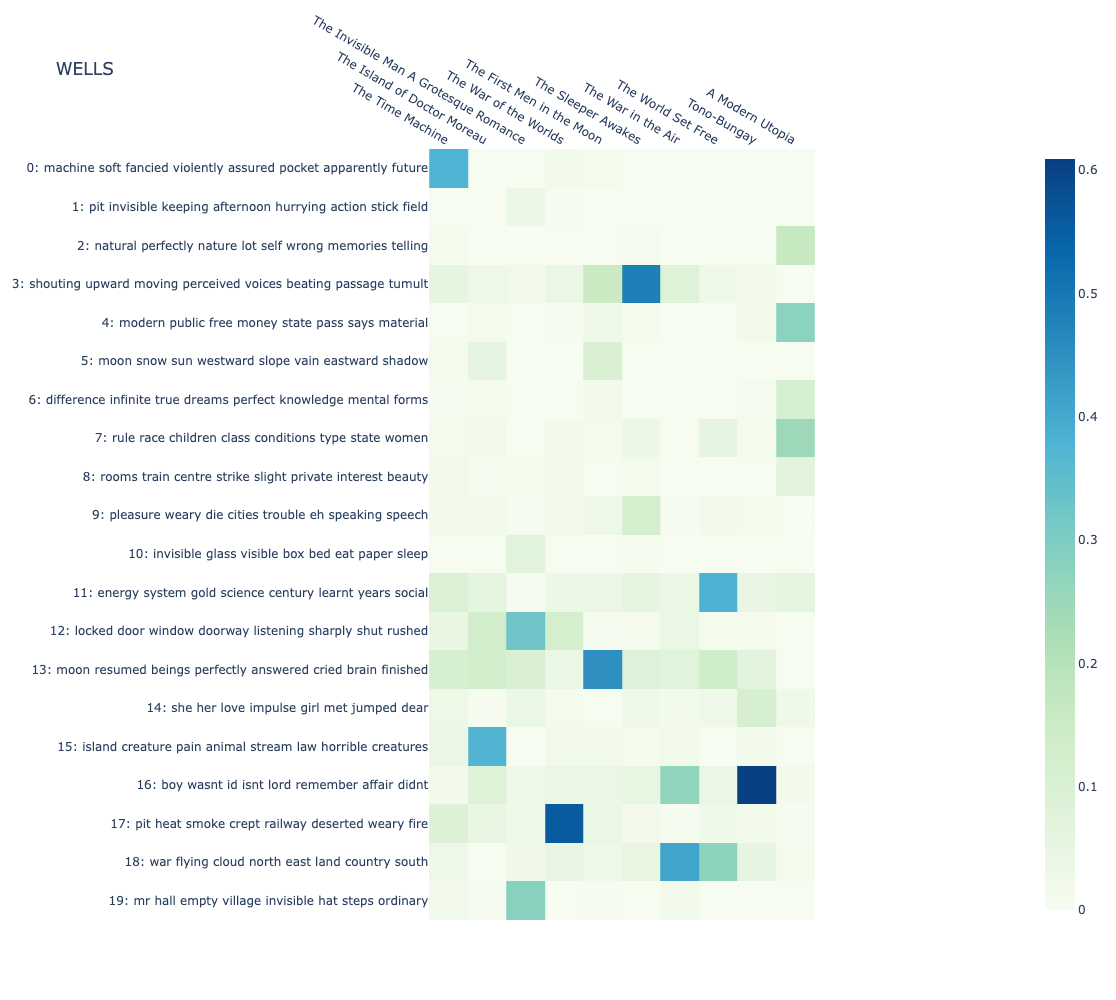

In [26]:
fig = px.imshow(WELLS_IMG.T, color_continuous_scale='GnBu', height=1000, title="WELLS")
fig.update_layout(xaxis={'side': 'top', 'title_text':None}, yaxis={'title_text':None})

## Topic Dendrograms

In [27]:
os.chdir(parser_lib)
from hac2 import HAC
os.chdir(home_dir)

<Figure size 432x288 with 0 Axes>

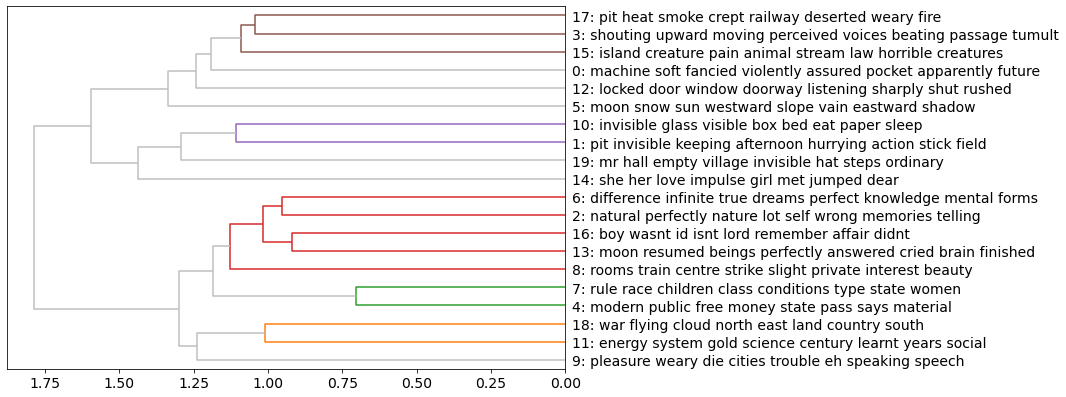

In [28]:
dend_WELLS_phi = HAC(tm_WELLS.PHI)
dend_WELLS_phi.labels = tm_WELLS.TOPIC.label.to_list()
dend_WELLS_phi.plot()

<Figure size 432x288 with 0 Axes>

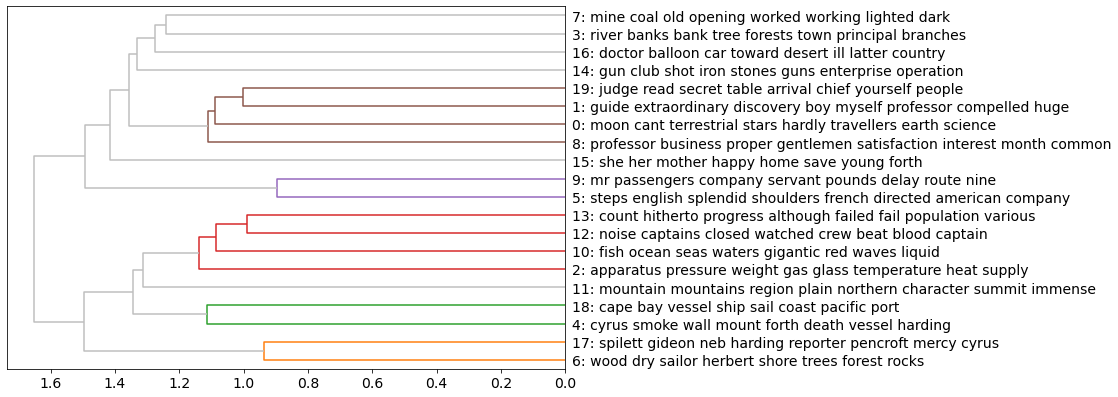

In [29]:
dend_VERNE_phi = HAC(tm_VERNE.PHI)
dend_VERNE_phi.labels = tm_VERNE.TOPIC.label.to_list()
dend_VERNE_phi.plot()

## Heatmaps of Topics within Books

In [30]:
def show_book_heatmap(tm, book_id, h=None, w=None, thresh=None):
    global LIB
    
    title = LIB.loc[book_id].title

    # Pick only those topics whose mean concentration is above threshhold
    if not thresh:
        thresh = tm.THETA.loc[book_id].mean().quantile(.8)
    X = tm.THETA.loc[book_id, tm.THETA.loc[book_id].mean() >= thresh]
    if not h:
        h = int(75 * len(X.T))
    if not w:
        w = int(16 * len(X))
    if w < 1000: w = 1000
    return px.imshow(X.T, 
                     width=w, height=h, aspect='equal',
                     color_continuous_scale='GnBu', 
                     labels=dict(y='topics',x='chapters'),
                     y=tm.TOPIC.loc[X.columns].label.values,
                     title=f"{title} / thresh={round(thresh, 2)}" 
    )

In [31]:
LIB.loc[WELLS_IDX].title

book_id
35                            The Time Machine
159                The Island of Doctor Moreau
5230     The Invisible Man A Grotesque Romance
36                       The War of the Worlds
1013                 The First Men in the Moon
12163                       The Sleeper Awakes
780                         The War in the Air
1059                        The World Set Free
718                                Tono-Bungay
6424                           A Modern Utopia
Name: title, dtype: object

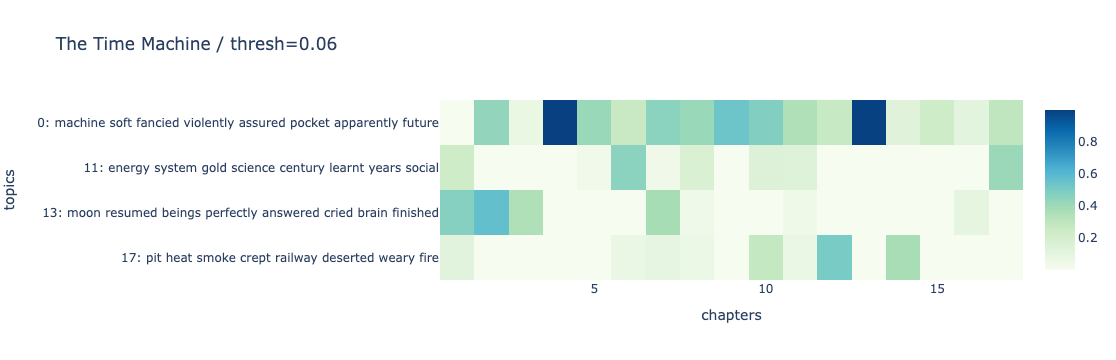

In [32]:
show_book_heatmap(tm_WELLS, 35)

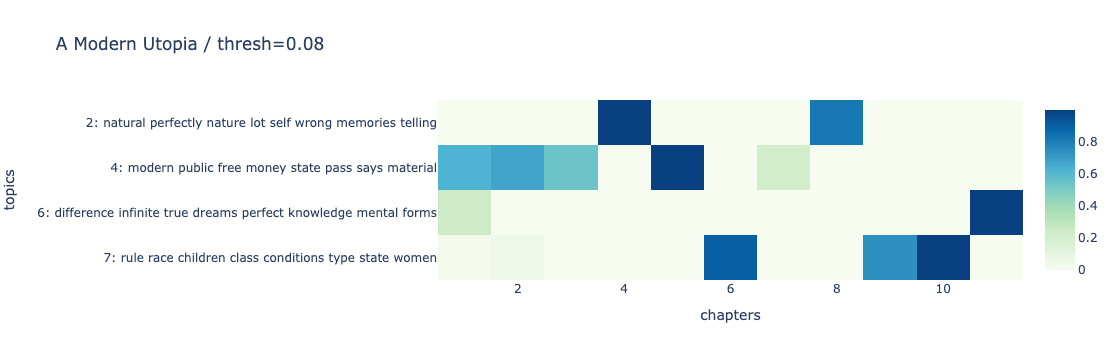

In [33]:
show_book_heatmap(tm_WELLS, 6424)

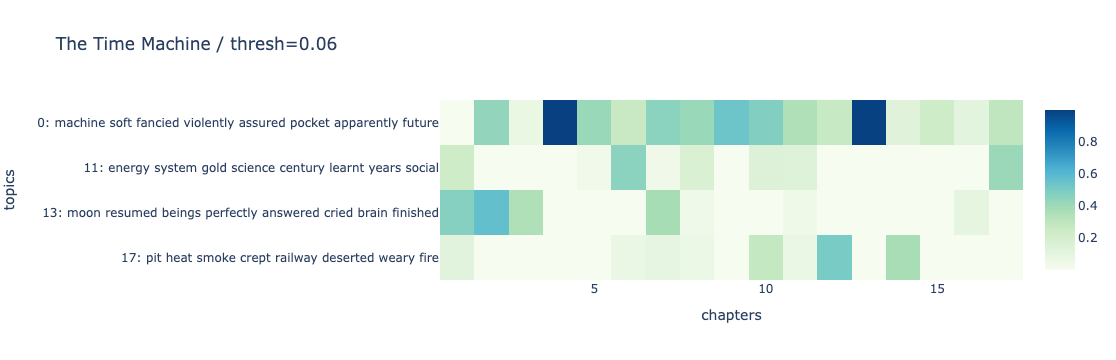

In [34]:
show_book_heatmap(tm_WELLS, 35)

In [35]:
LIB.loc[VERNE_IDX].title

book_id
44278               From the Earth to the Moon
1355                      The Underground City
103            Around the World in Eighty Days
18857     A Journey to the Centre of the Earth
3526                   Five Weeks in a Balloon
3091       Eight Hundred Leagues on the Amazon
16457                      All Around the Moon
1353                           Off on a Comet!
164      Twenty Thousand Leagues under the Sea
1268                     The Mysterious Island
Name: title, dtype: object

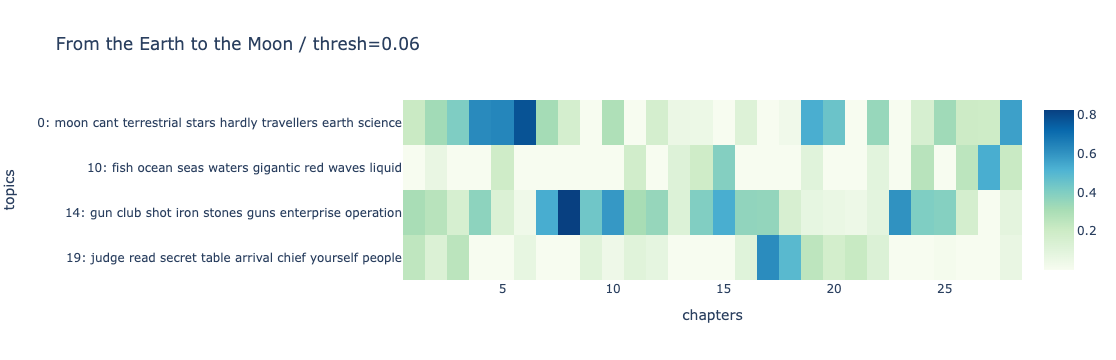

In [36]:
show_book_heatmap(tm_VERNE, 44278)

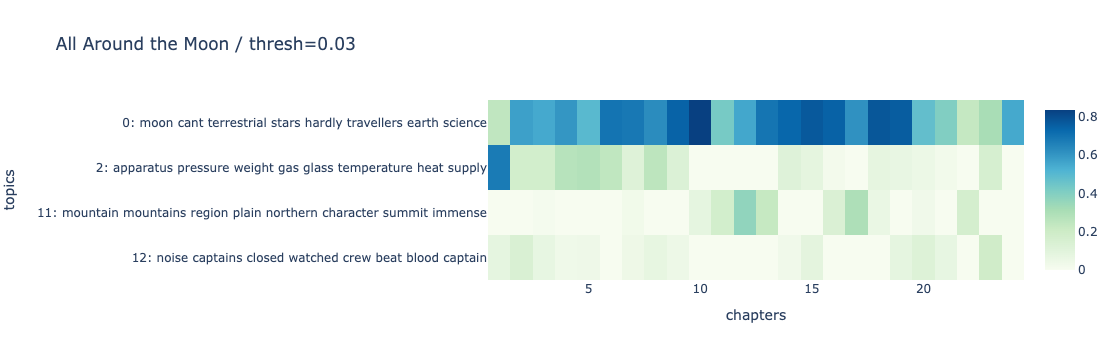

In [37]:
show_book_heatmap(tm_VERNE, 16457)

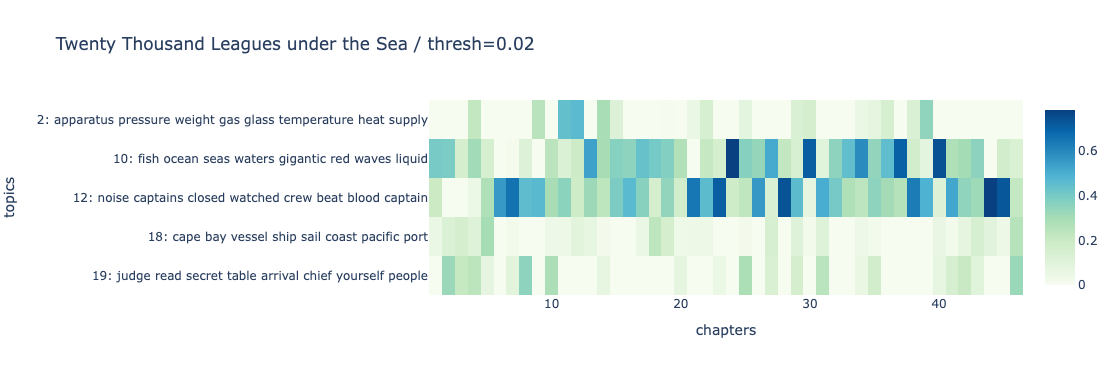

In [38]:
show_book_heatmap(tm_VERNE, 164, thresh = .02)

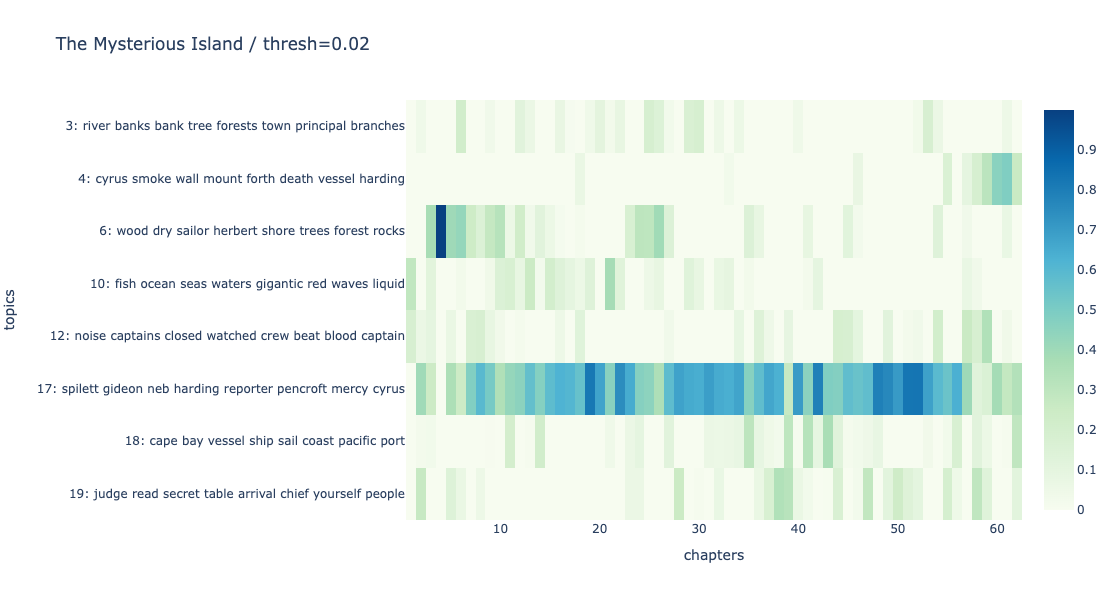

In [39]:
show_book_heatmap(tm_VERNE, 1268, thresh = .02)

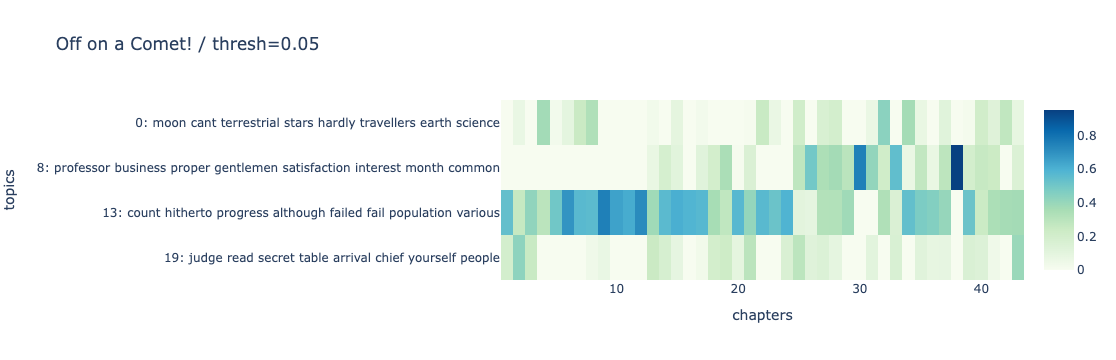

In [40]:
show_book_heatmap(tm_VERNE, 1353)

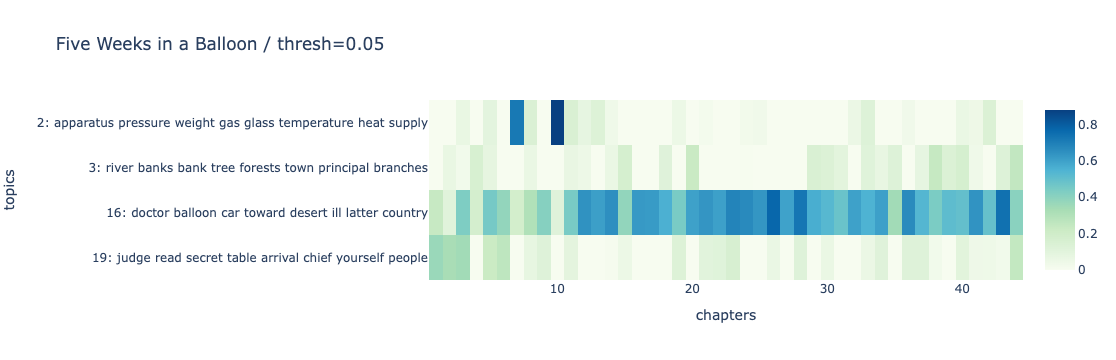

In [41]:
show_book_heatmap(tm_VERNE, 3526)

# Visualize with t-SNE

In [42]:
from sklearn.manifold import TSNE

In [43]:
def plot_phi(model):
    X = model.PHI
    pp = model.TOPIC.h.mean()
    print(pp)
    T = model.TOPIC.join(pd.DataFrame(TSNE(n_components=2, learning_rate='auto', perplexity=pp, init='random').fit_transform(X)))
    fig = px.scatter(T, 0, 1, width=600, height=500, 
                     size=f'phi_sum', 
                     hover_name='label', 
                     text=model.TOPIC.index)  
    fig.show()

8.269499999999997


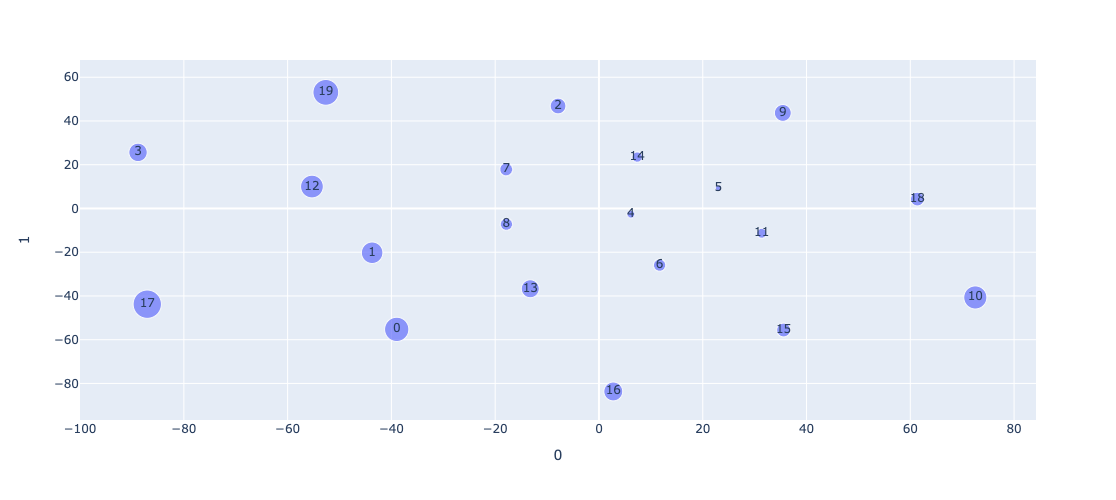

In [44]:
plot_phi(tm_VERNE)

8.3405


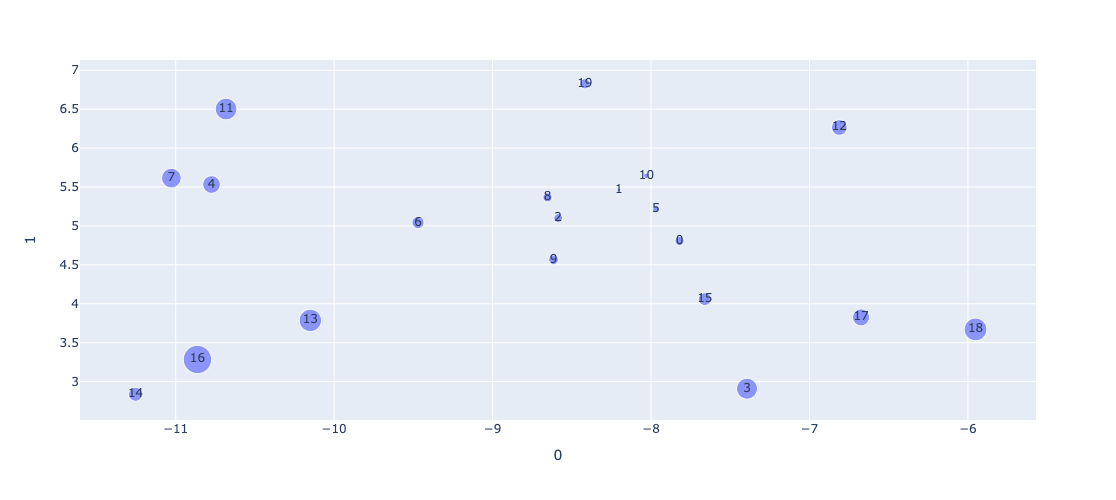

In [45]:
plot_phi(tm_WELLS)

In [46]:
def plot_theta(model):
    X = model.THETA
    pp = n_topics
    T = pd.DataFrame(TSNE(n_components=2, learning_rate='auto', perplexity=pp, init='random').fit_transform(X), index=X.index)
    T = T.join(model.DOC)
    fig = px.scatter(T, 0, 1, height=1000, width=1200, 
               hover_name=T.label, 
               color='title', 
               marginal_x='box', 
               marginal_y='box'
          )    
    fig.show()

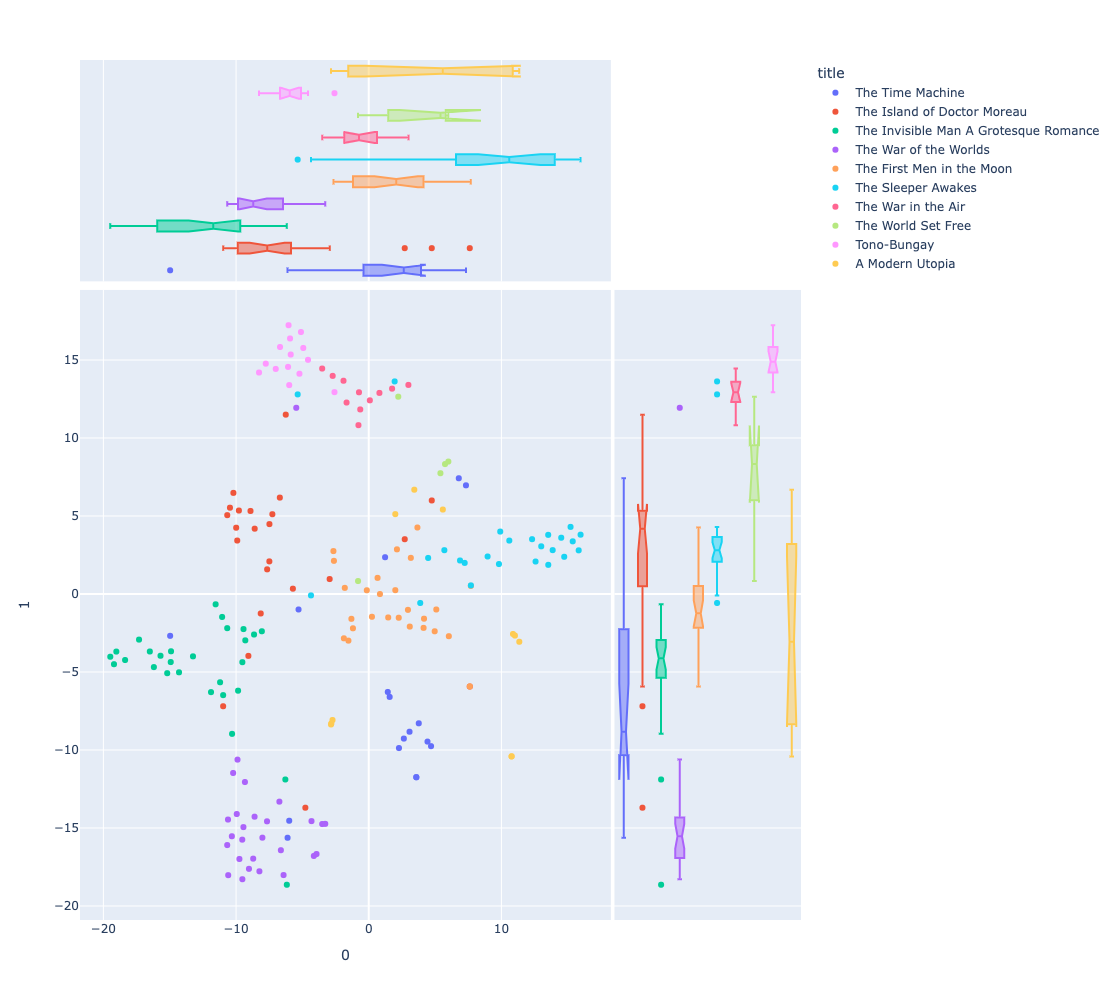

In [47]:
plot_theta(tm_WELLS)

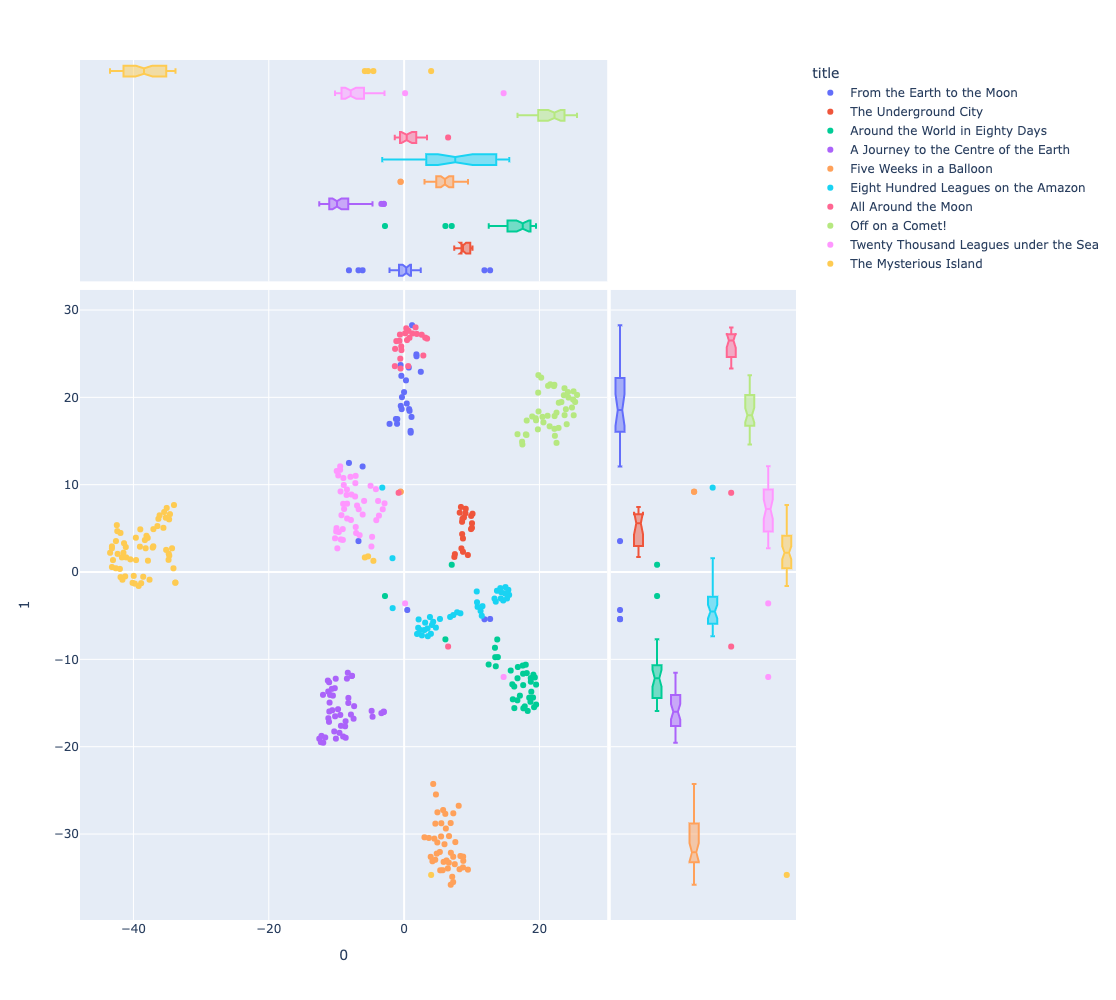

In [48]:
plot_theta(tm_VERNE)

# Save

In [49]:
tm_WELLS.TOPIC.to_csv(f'{data_home}/output/WELLS-LDA_TOPIC-{n_topics}.csv')
tm_WELLS.THETA.to_csv(f'{data_home}/output/WELLS-LDA_THETA-{n_topics}.csv')
tm_WELLS.PHI.to_csv(f'{data_home}/output/WELLS-LDA_PHI-{n_topics}.csv')

In [50]:
tm_VERNE.TOPIC.to_csv(f'{data_home}/output/VERNE-LDA_TOPIC-{n_topics}.csv')
tm_VERNE.THETA.to_csv(f'{data_home}/output/VERNE-LDA_THETA-{n_topics}.csv')
tm_VERNE.PHI.to_csv(f'{data_home}/output/VERNE-LDA_PHI-{n_topics}.csv')